In [144]:
import pickle
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.covariance import LedoitWolf, OAS

In [145]:
def filterByEdge(g, corr, cutOff, keepOnlyMain):
    # Filtering edges
    corr = g.edge_properties[corr]
    sign = g.new_ep("bool", True)
    sign.a = np.array(np.abs(corr.a) > cutOff)

    tv = GraphView(g, efilt=sign)

    # Keeping largest component
    if keepOnlyMain:
        comp, hist = label_components(tv)
        main_component = tv.new_vp("bool", (comp.a == np.where(hist == max(hist))[0][0]))
        tv.vertex_properties["main_component"] = main_component
        tv.set_vertex_filter(main_component)
    return tv

In [146]:
# Set residuals file input name, tsv format
residuals_file = "rawData/batch/example.tsv"

In [147]:
gene_expr_raw = pd.read_table(residuals_file)
gene_expr = gene_expr_raw.T
gene_expr

ENSG00000198040.10  ENSG00000145495.15  \
GTEX.13OVK.2226.SM.6LPJY.1            6.416047            6.989785   
GTEX.14E6E.1026.SM.664N9.1            5.917372            7.249048   
GTEX.15RIF.1826.SM.6M469.1            5.958476            7.242611   
GTEX.1A8G6.2526.SM.72D59.1            6.381916            7.573262   
GTEX.1AX9K.1826.SM.731CY.1            5.857638            7.487593   
...                                        ...                 ...   
GTEX.1GN2E.0126.SM.9OSW8.1            6.233497            7.146737   
GTEX.1HUB1.2026.SM.A96S8.1            5.596040            7.153504   
GTEX.1I1GS.1826.SM.C1YS8.1            6.111983            7.278984   
GTEX.1LBAC.1826.SM.D3L9X.1            5.811562            7.248729   
GTEX.1MCQQ.2326.SM.DLHBX.1            5.961644            6.912948   

                            ENSG00000108953.16  ENSG00000126091.19  \
GTEX.13OVK.2226.SM.6LPJY.1            8.203434            4.354814   
GTEX.14E6E.1026.SM.664N9.1            8.612646            4.914245   
GTEX.15RIF.1826.SM.6M469.1            8.572534            4.870710   
GTEX.1A8G6.2526.SM.72D59.1            8.593044            4.509698   
GTEX.1AX9K.1826.SM.731CY.1            8.554431            5.020411   
...                                        ...                 ...   
GTEX.1GN2E.0126.SM.9OSW8.1            8.449787            5.129842   
GTEX.1HUB1.2026.SM.A96S8.1            8.489587            5.637837   
GTEX.1I1GS.1826.SM.C1YS8.1            8.315719            4.941048   
GTEX.1LBAC.1826.SM.D3L9X.1            8.542342            5.109788   
GTEX.1MCQQ.2326.SM.DLHBX.1            8.512139            5.293651   

                            ENSG00000116641.17  ENSG00000065150.18  \
GTEX.13OVK.2226.SM.6LPJY.1            5.928165            8.513165   
GTEX.14E6E.1026.SM.664N9.1            6.151454            8.869307   
GTEX.15RIF.1826.SM.6M469.1            6.224258            8.963023   
GTEX.1A8G6.2526.SM.72D59.1            6.801388            7.892000   
GTEX.1AX9K.1826.SM.731CY.1            6.266200            8.362524   
...                                        ...                 ...   
GTEX.1GN2E.0126.SM.9OSW8.1            5.760843            9.147471   
GTEX.1HUB1.2026.SM.A96S8.1            5.578612            9.011948   
GTEX.1I1GS.1826.SM.C1YS8.1            5.871401            8.989989   
GTEX.1LBAC.1826.SM.D3L9X.1            6.189804            9.150551   
GTEX.1MCQQ.2326.SM.DLHBX.1            5.676277            8.929174   

                            ENSG00000166595.11  ENSG00000196510.12  \
GTEX.13OVK.2226.SM.6LPJY.1            6.242571            6.142777   
GTEX.14E6E.1026.SM.664N9.1            6.373150            6.016199   
GTEX.15RIF.1826.SM.6M469.1            5.848807            6.153567   
GTEX.1A8G6.2526.SM.72D59.1            6.318600            6.418337   
GTEX.1AX9K.1826.SM.731CY.1            6.106859            6.241341   
...                                        ...                 ...   
GTEX.1GN2E.0126.SM.9OSW8.1            6.032420            6.161223   
GTEX.1HUB1.2026.SM.A96S8.1            6.275936            6.129113   
GTEX.1I1GS.1826.SM.C1YS8.1            6.052463            6.072267   
GTEX.1LBAC.1826.SM.D3L9X.1            5.918518            6.062432   
GTEX.1MCQQ.2326.SM.DLHBX.1            5.906960            6.150990   

                            ENSG00000253731.2  ENSG00000142192.20  ...  \
GTEX.13OVK.2226.SM.6LPJY.1           6.365438            9.642635  ...   
GTEX.14E6E.1026.SM.664N9.1           6.454449            9.824143  ...   
GTEX.15RIF.1826.SM.6M469.1           6.343017            9.865066  ...   
GTEX.1A8G6.2526.SM.72D59.1           6.547584            9.948083  ...   
GTEX.1AX9K.1826.SM.731CY.1           6.585903           10.041185  ...   
...                                       ...                 ...  ...   
GTEX.1GN2E.0126.SM.9OSW8.1           6.210915            9.356075  ...   
GTEX.1HUB1.2026.SM.A96S8.1           6.296277            9.123279  ...  

In [148]:
# Get gene names from the columns of gene_expr
gene_names = gene_expr.columns.tolist()
gene_names

['ENSG00000198040.10',
 'ENSG00000145495.15',
 'ENSG00000108953.16',
 'ENSG00000126091.19',
 'ENSG00000116641.17',
 'ENSG00000065150.18',
 'ENSG00000166595.11',
 'ENSG00000196510.12',
 'ENSG00000253731.2',
 'ENSG00000142192.20',
 'ENSG00000250182.3',
 'ENSG00000178904.18',
 'ENSG00000104613.11',
 'ENSG00000166199.12',
 'ENSG00000125743.10',
 'ENSG00000179833.4',
 'ENSG00000137814.10',
 'ENSG00000143624.13',
 'ENSG00000107404.19',
 'ENSG00000144320.13',
 'ENSG00000179632.9',
 'ENSG00000111667.13',
 'ENSG00000130311.10',
 'ENSG00000198589.10',
 'ENSG00000164024.11',
 'ENSG00000126804.13',
 'ENSG00000169439.11',
 'ENSG00000184602.5',
 'ENSG00000142002.16',
 'ENSG00000146859.6',
 'ENSG00000230383.1',
 'ENSG00000170310.14',
 'ENSG00000135404.11',
 'ENSG00000189376.11',
 'ENSG00000268220.1',
 'ENSG00000153187.18',
 'ENSG00000124608.4',
 'ENSG00000141295.13',
 'ENSG00000258210.1',
 'ENSG00000185920.15',
 'ENSG00000068024.16',
 'ENSG00000158019.20',
 'ENSG00000186716.20',
 'ENSG00000171492.14'

In [149]:
ge_centered = (gene_expr - gene_expr.mean()) / np.sqrt(gene_expr.var())

# Fit a covariance matrix to the centered and scaled gene expression data
# OAS shrinkage estimator: https://www.cs.huji.ac.il/~amiw/chen_tsp_2010.pdf
# https://scikit-learn.org/stable/auto_examples/covariance/plot_lw_vs_oas.html
oa = OAS(store_precision=True, assume_centered=True)
gene_expr_OAS_corr = oa.fit(ge_centered)
s_cov = gene_expr_OAS_corr.covariance_
n_genes = s_cov.shape[1]
n_genes

1000

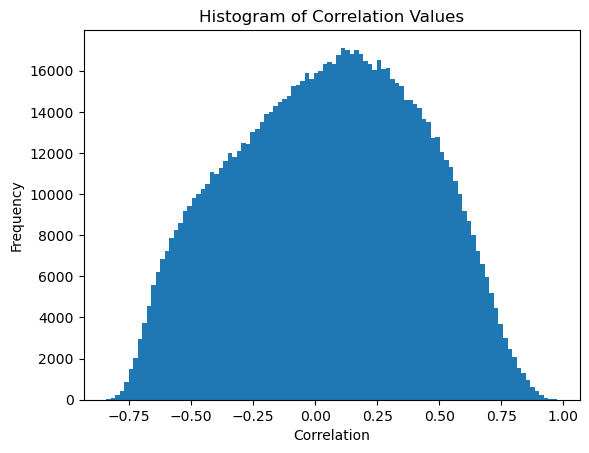

In [150]:
# Set scov diagonal to zero
np.fill_diagonal(s_cov, 0)
s_cov

# Plot histogram of s_cov   
import matplotlib.pyplot as plt
plt.hist(s_cov[s_cov != 0], bins=100)
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.title("Histogram of Correlation Values")
plt.show()  

In [ ]:
# Set absolute covariances lower than cutOff to zero
s_cov_filter = s_cov.copy()

cutOff = 0.5
s_cov_filter[abs(s_cov_filter) < cutOff] = 0

# Filter gene names based on the covariance matrix
filtered_gene_names = [gene_names[i] for i in range(len(gene_names)) if not np.all(s_cov_filter[i, :] == 0) and not np.all(s_cov_filter[:, i] == 0)]

# Remove rows and columns with all zeros
s_cov_filter = s_cov_filter[~np.all(s_cov_filter == 0, axis=1)]
s_cov_filter = s_cov_filter[:, ~np.all(s_cov_filter == 0, axis=0)]

962

In [ ]:
# Set lower triangle to zero
s_cov_filter = np.triu(s_cov_filter, k=1)

# Arctanh transform correlations to make them real-valued
s_cov_filter = 2*np.arctanh(s_cov_filter)

# Create graph using graph-tool and filtered correlations as edge weights
g = Graph(sp.sparse.lil_matrix(s_cov_filter), directed=False)

# Add filtered gene names as vertex properties
g.vp.gene = g.new_vp("string", filtered_gene_names)

# Check graph density
density = g.num_edges() / ((n_genes * n_genes - n_genes) / 2 )
print(f"Graph density: {density:.4f}")

Graph density: 0.2133


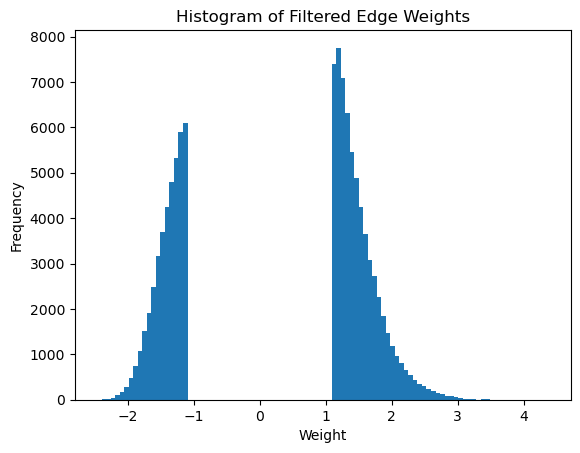

In [157]:
# Histogram of filtered edge weights
plt.hist(g.ep.weight.a, bins=100)
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.title("Histogram of Filtered Edge Weights")
plt.show()

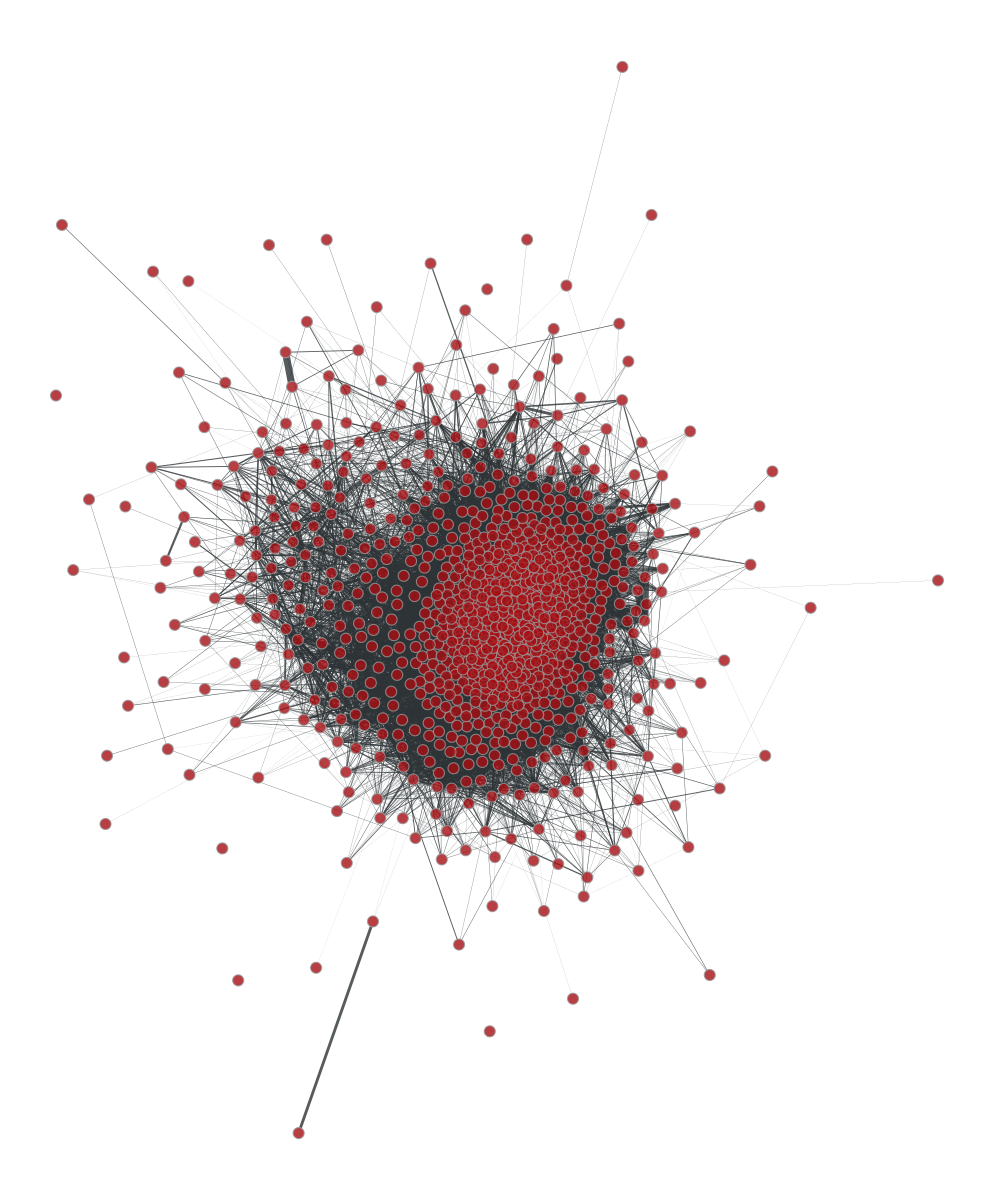

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9320f5da00, at 0x7f8f77720b30>

In [159]:
# Add absolute value of weight property for visualization
g.ep.abs_weight = g.new_edge_property("double", np.abs(g.ep.weight.fa))

graph_draw(g, edge_pen_width = prop_to_size(g.ep.abs_weight, mi=0, ma=4, power=1, log=False))


In [123]:
state = minimize_nested_blockmodel_dl(
    g, 
    state_args=dict(recs=[g.ep.weight],
                    rec_types=["real-normal"]))

In [124]:
S1 = state.entropy()
mcmc_anneal(state, beta_range=(1, 10), niter=1000,
            mcmc_equilibrate_args=dict(force_niter=10), verbose=False)
S2 = state.entropy()
print("Improvement from annealing: " + str(S2 - S1))

Improvement from annealing: -3029.959229111584


In [125]:
S1 = state.entropy()
mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10), verbose=False)
S2 = state.entropy()
print("Improvement from equilibration: " + str(S2 - S1))

Improvement from equilibration: -104.59184940141859


In [ ]:
bstate = state.levels[0]
pos = sfdp_layout(state.get_bstack()[0], groups=bstate.get_blocks(), gamma=.02)

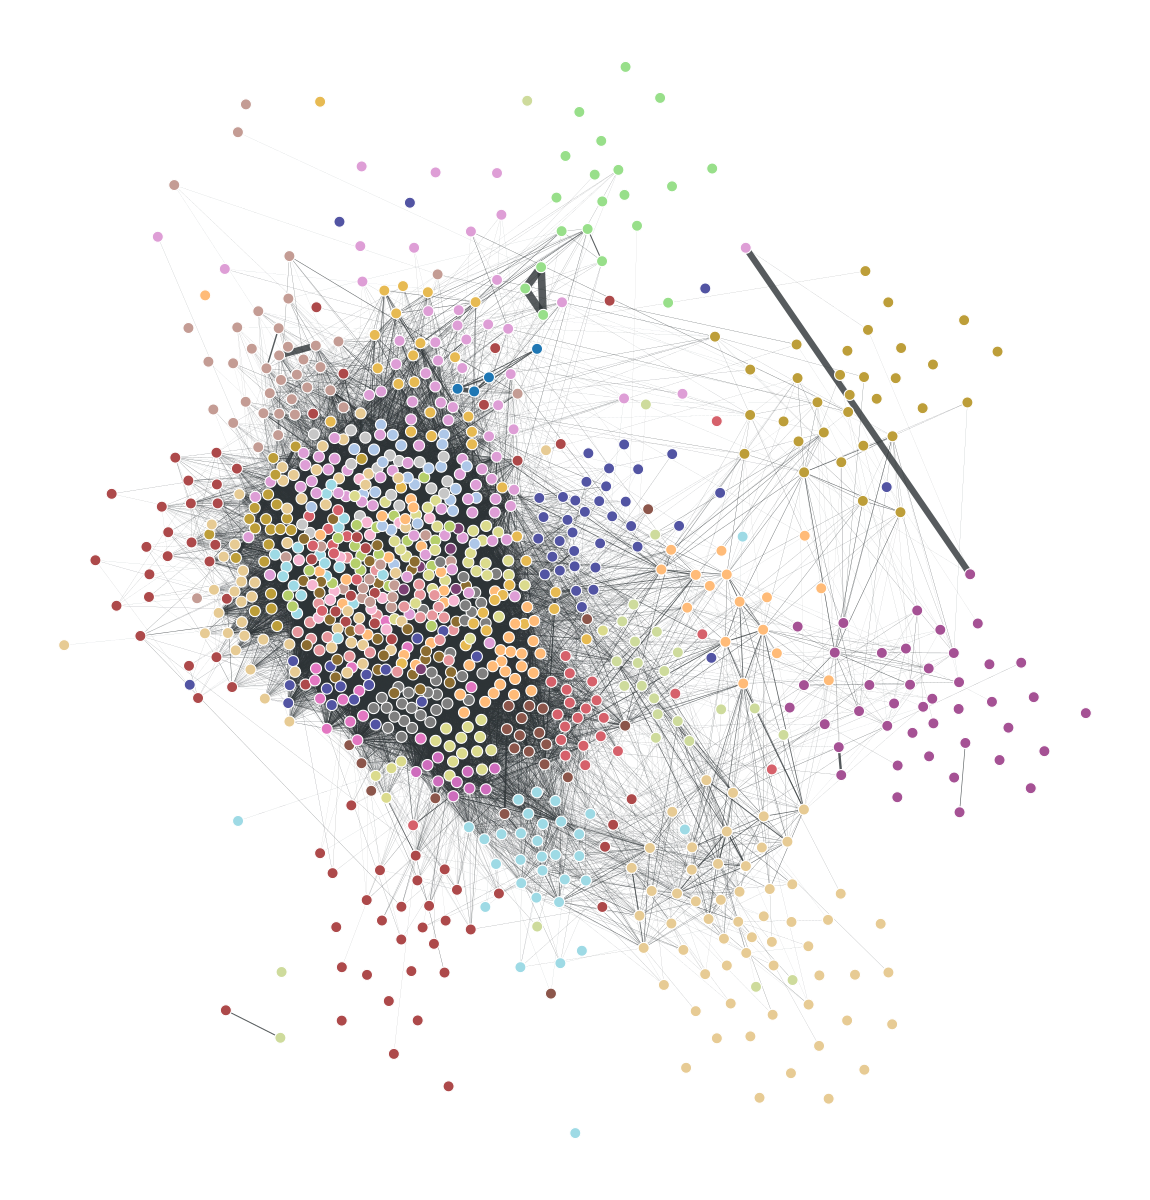

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8f76832b40, at 0x7f8f769a8dd0>

In [134]:
bstate.draw(pos=pos, vertex_color="white", edge_gradient=[],
            edge_pen_width=prop_to_size(g.ep.abs_weight, mi=0, ma=4, power=2, log=False))

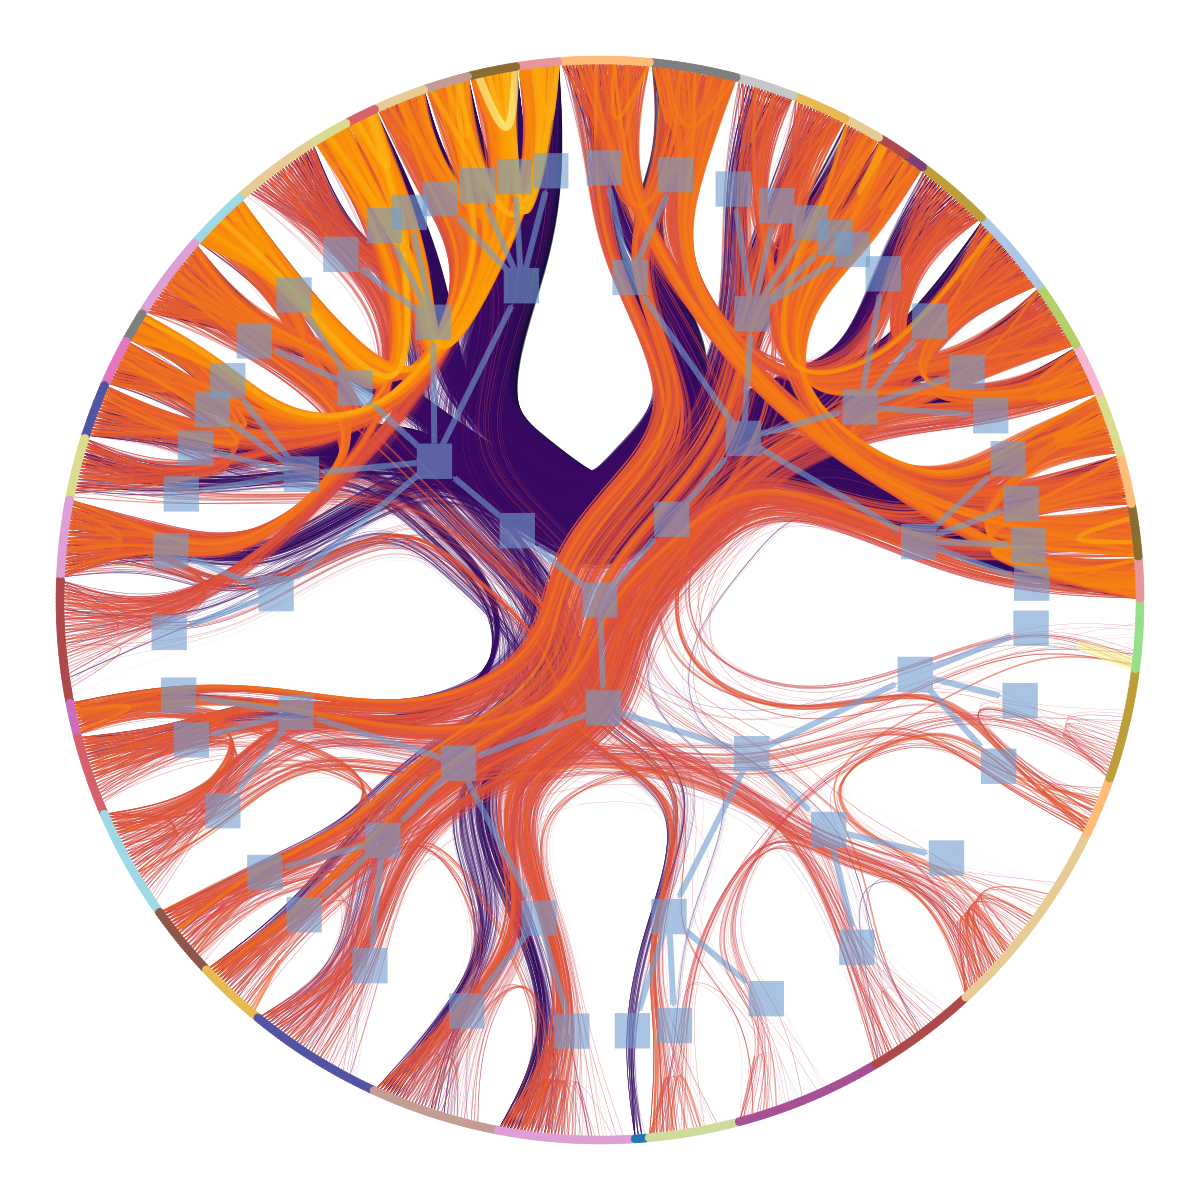

In [135]:
import matplotlib.pyplot as plt
import matplotlib.cm as mpl

g.vp.level_0 = g.new_vertex_property("double", state.get_bs()[0])
g.ep.abs_weight = g.new_edge_property("double", np.abs(g.ep.weight.fa))
pos_t, twat, tpos = state.draw( eorder=g.ep.weight,
        edge_pen_width = prop_to_size(g.ep.abs_weight, mi=0, ma=4, power=1, log=False),
        edge_color=prop_to_size(g.ep.weight, mi=-4, ma=4, power=1, log=False),
        ecmap=(mpl.inferno, .6), 
        edge_gradient=[], 
        vertex_size = 4,
        hvertex_size = 25,
        hedge_pen_width = 3,
        vertex_color = g.vp.level_0,
        vertex_fill_color = g.vp.level_0,
        subsample_edges = 10000)